In [1]:
import os
import io
from contextlib import redirect_stdout
import warnings
import re
import time
import random

from pgmpy.base import DAG
from pgmpy.models import BayesianModel
from pgmpy.estimators import PC, HillClimbSearch, BicScore
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import openai

In [2]:
warnings.filterwarnings('ignore')

## Retry Decorator

In [3]:
# Define a retry decorator
def retry_with_exponential_backoff(
    func,
    initial_delay: float = 1,
    exponential_base: float = 2,
    jitter: bool = True,
    max_retries: int = 10,
    errors: tuple = (openai.error.RateLimitError,)
):
    """
    Retry a function with exponential backoff.
    """

    def wrapper(*args, **kwargs):
        # Initialize variables
        num_retries = 0
        delay = initial_delay

        # Loop until a successful response or max_retries is hit or an exception is raised
        while True:
            try:
                return func(*args, **kwargs)

            # Retry on specified errors
            except errors as e:
                # Increment retries
                num_retries += 1

                # Check if max retries has been reached
                if num_retries > max_retries:
                    raise Exception(
                        f"Maximum number of retries ({max_retries}) exceeded."
                    )

                # Increment the delay
                delay *= exponential_base * (1 + jitter * random.random())

                # Sleep for the delay
                time.sleep(delay)

            # Raise exceptions for any errors not specified
            except Exception as e:
                raise e

    return wrapper

## Print Full

In [4]:
def print_full(cpd: TabularCPD) -> None:
    """
    Print the full CPD table.

    Parameters
    ----------
    cpd : TabularCPD
        The CPD to print.

    Returns
    -------
    None
        CPD table is printed to stdout and no value is returned.
    """
    # Temporarily change the truncation setting
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    # Restore the original setting
    TabularCPD._truncate_strtable = backup
    
    return None

## ChatGPT Class

Different models:

* text-davinci-002 (default): a highly capable and versatile model for natural language processing tasks, such as text completion, question answering, and summarization.

* text-curie-001: a highly capable model that performs well across a wide range of natural language processing tasks, with a focus on conversational agents.
  
* text-babbage-001: a model that excels at text completion tasks and can generate high-quality responses to prompts related to factual information, such as encyclopedia entries and news articles.
  
* text-ada-001: a model that specializes in natural language processing tasks related to language translation, summarization, and question answering, with a focus on efficient computation and low latency.

In [5]:
4097 * 0.75

3072.75

In [18]:
class ChatGPT:
    def __init__(self, api_key: str):
        """
        Constructor for ChatGPT class.

        Parameters
        ----------
        api_key : str
            OpenAI API key.
        """
        self.api_key = api_key
        openai.api_key = self.api_key
        self.model = "text-davinci-003" 
    
    @retry_with_exponential_backoff
    def ask(self, prompt: str) -> str:
        """
        Prompt the model with a question.

        Parameters
        ----------
        prompt : str
            The prompt to ask the model.

        Returns
        -------
        str
            The model's response.
        """
        response = openai.Completion.create(
            model=self.model,
            prompt=prompt,
            max_tokens=2048,
            temperature=0.7,
            n=1,
            stop=None
        )
        message = response.choices[0].text.strip()
        return message

### Tests

In [19]:
chatbot = ChatGPT(os.environ["OPENAI_API_KEY"])

In [20]:
prompt_1 = """Hello Chatbot, how are you?"""

response_1 = chatbot.ask(prompt_1)

print(response_1)

I'm doing great, thank you for asking. How can I help you?


In [ ]:
edges = [('Risk Event: Supply Disruption', 'Consequence: Damage'), ('Mitigator: Response', 'Consequence: Damage'), ('Trigger: Event', 'Risk Event: Supply Disruption'), ('Control: Diversify Suppliers', 'Risk Event: Supply Disruption')]

prompt_2 = f'Given me the code that creates a Bayesian network using the pgmpy python package with the following: {edges}. Do not include the TabularCPD. Just give me the model.'

response_2 = chatbot.ask(prompt_2)

print(response_2)

creation code.

from pgmpy.models import BayesianModel 

# Create the Bayesian model
model = BayesianModel([('Trigger: Event', 'Risk Event: Supply Disruption'),
                       ('Risk Event: Supply Disruption', 'Consequence: Damage'),
                       ('Mitigator: Response', 'Consequence: Damage'),
                       ('Control: Diversify Suppliers', 'Risk Event: Supply Disruption')])


In [13]:
# Parse the string to get the model
response_2

"creation code.\n\nfrom pgmpy.models import BayesianModel \n\n# Create the Bayesian model\nmodel = BayesianModel([('Trigger: Event', 'Risk Event: Supply Disruption'),\n                       ('Risk Event: Supply Disruption', 'Consequence: Damage'),\n                       ('Mitigator: Response', 'Consequence: Damage'),\n                       ('Control: Diversify Suppliers', 'Risk Event: Supply Disruption')])"

Text(0.5, 1.0, 'Final Model Specification')

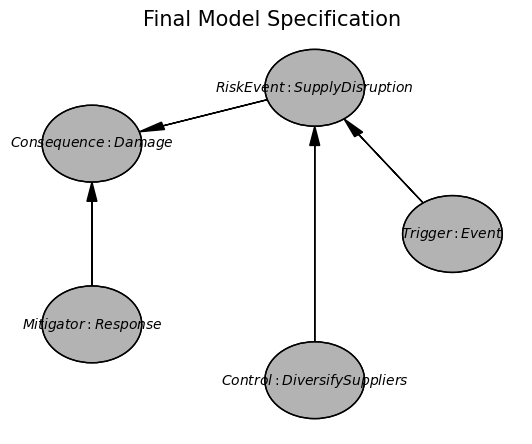

In [15]:
from pgmpy.models import BayesianModel 

# Create the Bayesian model
model = BayesianModel([('Trigger: Event', 'Risk Event: Supply Disruption'),
                       ('Risk Event: Supply Disruption', 'Consequence: Damage'),
                       ('Mitigator: Response', 'Consequence: Damage'),
                       ('Control: Diversify Suppliers', 'Risk Event: Supply Disruption')])

ax = model.to_daft().render()
ax.figure.set_size_inches(5, 4)
ax.set_title('Final Model Specification', fontsize=15)

### Example Prompt for User (Expert)

In [16]:
"what do you think is the risk associated with the following activity 'feature complete': low, medium, or high?"

response_mapping = {
    'low': 0.25,
    'medium': 0.5,
    'high': 0.8
}

response_mapping

{'low': 0.25, 'medium': 0.5, 'high': 0.8}

### Example Duration Mapping

In [17]:
durations = ['less than 10', '10-20', '20-30', '30-40', '40-50']

{k:v for k,v in zip(durations, range(len(durations)))}

{'less than 10': 0, '10-20': 1, '20-30': 2, '30-40': 3, '40-50': 4}